In [1]:
import pandas as pd
import torch
import numpy as np
from datetime import datetime

# Load the CSV file using pandas
train_df = pd.read_csv('train.csv')
oil_df = pd.read_csv('oil.csv')

# fill missing values in dcoilwtico column with previous day's value
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].fillna(method='ffill')

# merge the two dataframes based on the 'date' column using left join
merged_df = pd.merge(train_df, oil_df[['date', 'dcoilwtico']], on='date', how='left')

# fill remaining missing values in dcoilwtico column with previous day's value
merged_df['dcoilwtico'] = merged_df['dcoilwtico'].fillna(method='ffill')

df = merged_df#pd.read_csv('train.csv')

# Extract the label column and convert to a PyTorch tensor
ids = torch.tensor(df['id'].values, dtype=torch.float)
#date = torch.tensor(df['date'].values)
store_nbr = torch.tensor(df['store_nbr'].values)
train_sales = torch.tensor(df['sales'].values, dtype=torch.float)
onpromotion = torch.tensor(df['onpromotion'].values)
dcoilwtico = torch.tensor(df['dcoilwtico'].values, dtype=torch.float)


# Convert string dates to datetime objects
dates = pd.to_datetime(df['date'], format='%Y-%m-%d')
#I suppose that day of week is important to predict sales
day_of_week = dates.dt.weekday + 1
day_of_week = torch.from_numpy(day_of_week.to_numpy())
day_of_week = day_of_week.type(torch.float32)

day_of_month = dates.dt.day
day_of_month = torch.from_numpy(day_of_month.to_numpy())
day_of_month = day_of_month.type(torch.float32)
day_since_paycheck = []
for i in day_of_month:
    if(i>=15 and i <31):
        day_since_paycheck.append(i-15)
    if(i<15):
        day_since_paycheck.append(i)
    if (i == 31):
        day_since_paycheck.append(0) #more dirt, but better data
#Да это высчиытвается криво. Но сейчас пять утра, и мне лень это чинить. Если MSE станет ниже - починю
day_since_paycheck = torch.FloatTensor(day_since_paycheck)

month = dates.dt.month + 1 
month = torch.from_numpy(month.to_numpy()).float()
# Subtract datetime object representing "2013-01-01" to get number of days
#days_since_2013_01_01 = (dates - datetime(2013, 1, 1)).dt.days

# Convert to PyTorch tensor
#date = torch.from_numpy(days_since_2013_01_01.to_numpy())
family = []

family_raw = df['family'].values
families = sorted(list(set(family_raw)))
stoi = {s:i+1 for i,s in enumerate(families)}
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
for i in family_raw:
    family.append(stoi[i])

family = torch.FloatTensor(family)




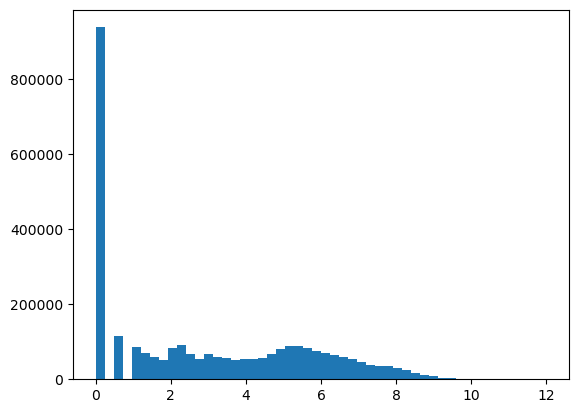

11.73381
tensor(2.6951)
0.0


In [2]:
import matplotlib.pyplot as plt
train_sales_log = np.log(train_sales+1)
data_range = train_sales_log.numpy().max() - train_sales_log.numpy().min()
# choose the number of bins based on the range of the data
#num_bins = min(50, int(data_range / 10))
num_bins = 50
hist_range = (0, int(train_sales_log.numpy().max())+1)
plt.hist(train_sales_log.numpy(), range=hist_range, bins=num_bins)
plt.show()
print(data_range)
print(train_sales_log.std())
print(train_sales_log.numpy().min())

In [3]:
print(ids.shape, ids.dtype)
#print(date.shape, date.dtype)
print(train_sales.shape, train_sales.dtype)
print(train_sales_log.shape, train_sales_log.dtype)
print(onpromotion.shape, onpromotion.dtype)
print(family.shape, family.dtype)
print(day_of_week.shape, day_of_week.dtype)
print(month.shape, month.dtype)
print(day_since_paycheck.shape, day_since_paycheck.dtype)
print(dcoilwtico.shape, dcoilwtico.dtype)

torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.int64
torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.float32
torch.Size([3000888]) torch.float32


In [4]:
train_data = torch.cat((month.unsqueeze(1), day_of_week.unsqueeze(1),day_since_paycheck.unsqueeze(1),
                        store_nbr.unsqueeze(1), family.unsqueeze(1),  onpromotion.unsqueeze(1),
                        dcoilwtico.unsqueeze(1)
                           ), dim=1)

print(train_data.dtype)
print(train_data.shape, train_data.dtype)
print(train_sales.shape, train_sales.dtype)

torch.float32
torch.Size([3000888, 7]) torch.float32
torch.Size([3000888]) torch.float32


In [5]:
# Shuffle the data and labels
indices = np.random.permutation(len(train_data))
train_data = train_data[indices]
train_sales = train_sales_log[indices]

# Define the percentage of data to be used for validation
val_percent = 0.2

# Calculate the number of validation samples
val_size = int(len(train_data) * val_percent)

# Split the data and labels into training and validation sets
val_data = train_data[:val_size]
train_data = train_data[val_size:]

val_sales = train_sales[:val_size]
train_sales = train_sales[val_size:]

print(val_data.shape)
print(val_sales.shape)
print(train_data.shape)
print(train_sales.shape)

torch.Size([600177, 7])
torch.Size([600177])
torch.Size([2400711, 7])
torch.Size([2400711])


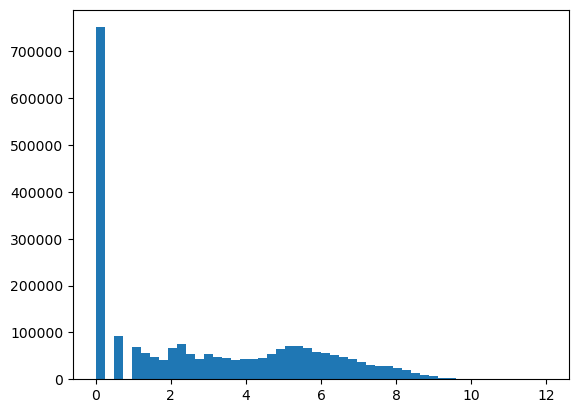

11.73381
std 2.695183753967285
mean 2.9265739917755127
min 0.0
max 11.733810424804688


In [6]:
import matplotlib.pyplot as plt
data_range = train_sales.numpy().max() - train_sales.numpy().min()
# choose the number of bins based on the range of the data
#num_bins = min(50, int(data_range / 10))
num_bins = 50
hist_range = (0, int(train_sales.numpy().max())+1)
plt.hist(train_sales.numpy(), range=hist_range, bins=num_bins)
plt.show()
print(data_range)
print(f'std {train_sales.std()}')
print(f'mean {train_sales.mean()}')
print(f'min {train_sales.min()}')
print(f'max {train_sales.max()}')

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [8]:
from torch import nn
import math

class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        rmsle = self.mse(torch.log(pred + 1), torch.log(actual + 1)) 
        return rmsle


In [9]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

class SalesPredictor(nn.Module):
    def __init__(self):
        super(SalesPredictor, self).__init__()
        self.fc1 = nn.Linear(7, 64) 
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1, bias=False)
        self.Leaky_ReLu = nn.LeakyReLU()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = self.Leaky_ReLu(x)
        x = self.fc3(x)
        x = self.Leaky_ReLu(x)
        x = self.fc4(x)
        x = self.relu(x)
        return x
    
    # Instantiate the neural network
model = SalesPredictor()
print(model)

SalesPredictor(
  (fc1): Linear(in_features=7, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=False)
  (Leaky_ReLu): LeakyReLU(negative_slope=0.01)
  (relu): ReLU()
)


In [10]:
from torch.utils.data import TensorDataset, DataLoader
# Define the loss function and optimizer
criterion = RMSLELoss()
optimizer = optim.Adam(model.parameters())

# Convert the data and labels to PyTorch datasets
train_dataset = TensorDataset(train_data, train_sales)
val_dataset = TensorDataset(val_data, val_sales)
# Define batch size for training and validation dataloaders
batch_size = 768
# Create data loaders for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,num_workers=10)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,num_workers=10)
save_every = 1
train_iterations = 2000


In [11]:
running_loss_es = []

In [12]:
def train():
    for epoch in range(train_iterations):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            print (f'Training epoch {epoch} iteration {i} of {len(train_loader)}', end = '\r'),
            optimizer.zero_grad()
            outputs = model(inputs)
            labels = labels.squeeze(-1)
            outputs = outputs.squeeze(-1)
            raw_out = outputs
            #returning to real values instead of logs
            labels = torch.exp(labels)-1
            outputs = torch.exp(outputs)-1
            loss = criterion(outputs, labels)
            if (math.isnan(loss)):
                print(f'inputs = {inputs}')
                print(f'outputs = {outputs}')
                print(f'raw outputs = {raw_out}')
                print(f'expected ={labels}')
                print(f'NaN error on epoch {epoch}\n')
                for param in model.parameters():
                    print(param.data)
                return
                break
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'\nEpoch {epoch} loss: {running_loss/len(train_loader)}')
        running_loss_es.append(running_loss/len(train_loader))
        if (epoch % save_every == 0):
            model_file_name = f'weights/model_weights_{epoch}.pth'
            print(f'Saving model as {model_file_name}')
            torch.save(model, model_file_name)
        torch.save(model, f'weights/model_weights_{train_iterations}.pth')
train()
print("Done")

Training epoch 0 iteration 3125 of 3126
Epoch 0 loss: 4.134407940996967
Saving model as weights/model_weights_0.pth
Training epoch 1 iteration 3125 of 3126
Epoch 1 loss: 3.7141583406688765
Saving model as weights/model_weights_1.pth
Training epoch 2 iteration 3125 of 3126
Epoch 2 loss: 3.451786157723352
Saving model as weights/model_weights_2.pth
Training epoch 3 iteration 3125 of 3126
Epoch 3 loss: 3.1339984158255394
Saving model as weights/model_weights_3.pth
Training epoch 4 iteration 3125 of 3126
Epoch 4 loss: 2.786069917053423
Saving model as weights/model_weights_4.pth
Training epoch 5 iteration 3125 of 3126
Epoch 5 loss: 2.6459888219070677
Saving model as weights/model_weights_5.pth
Training epoch 6 iteration 3125 of 3126
Epoch 6 loss: 2.5363680907952353
Saving model as weights/model_weights_6.pth
Training epoch 7 iteration 3125 of 3126
Epoch 7 loss: 2.396593449135583
Saving model as weights/model_weights_7.pth
Training epoch 8 iteration 3125 of 3126
Epoch 8 loss: 2.217872413777

Training epoch 69 iteration 3125 of 3126
Epoch 69 loss: 0.7315191827423666
Saving model as weights/model_weights_69.pth
Training epoch 70 iteration 3125 of 3126
Epoch 70 loss: 0.7189345448465585
Saving model as weights/model_weights_70.pth
Training epoch 71 iteration 3125 of 3126
Epoch 71 loss: 0.7305436151213014
Saving model as weights/model_weights_71.pth
Training epoch 72 iteration 3125 of 3126
Epoch 72 loss: 0.7180283386701204
Saving model as weights/model_weights_72.pth
Training epoch 73 iteration 3125 of 3126
Epoch 73 loss: 0.6991535792137977
Saving model as weights/model_weights_73.pth
Training epoch 74 iteration 3125 of 3126
Epoch 74 loss: 0.7106658265385503
Saving model as weights/model_weights_74.pth
Training epoch 75 iteration 3125 of 3126
Epoch 75 loss: 0.7136222965638758
Saving model as weights/model_weights_75.pth
Training epoch 76 iteration 3125 of 3126
Epoch 76 loss: 0.7018592069145967
Saving model as weights/model_weights_76.pth
Training epoch 77 iteration 3125 of 3126

Training epoch 137 iteration 3125 of 3126
Epoch 137 loss: 0.5892174522120146
Saving model as weights/model_weights_137.pth
Training epoch 138 iteration 3125 of 3126
Epoch 138 loss: 0.5997965900621884
Saving model as weights/model_weights_138.pth
Training epoch 139 iteration 3125 of 3126
Epoch 139 loss: 0.5934332011128113
Saving model as weights/model_weights_139.pth
Training epoch 140 iteration 3125 of 3126
Epoch 140 loss: 0.5959453740450944
Saving model as weights/model_weights_140.pth
Training epoch 141 iteration 3125 of 3126
Epoch 141 loss: 0.6034455687589395
Saving model as weights/model_weights_141.pth
Training epoch 142 iteration 3125 of 3126
Epoch 142 loss: 0.5943987125760839
Saving model as weights/model_weights_142.pth
Training epoch 143 iteration 3125 of 3126
Epoch 143 loss: 0.596355401966256
Saving model as weights/model_weights_143.pth
Training epoch 144 iteration 3125 of 3126
Epoch 144 loss: 0.5888797999648657
Saving model as weights/model_weights_144.pth
Training epoch 14

Training epoch 204 iteration 3125 of 3126
Epoch 204 loss: 0.5530637413148917
Saving model as weights/model_weights_204.pth
Training epoch 205 iteration 3125 of 3126
Epoch 205 loss: 0.552406370515863
Saving model as weights/model_weights_205.pth
Training epoch 206 iteration 3125 of 3126
Epoch 206 loss: 0.5426955014676981
Saving model as weights/model_weights_206.pth
Training epoch 207 iteration 3125 of 3126
Epoch 207 loss: 0.5474625214200255
Saving model as weights/model_weights_207.pth
Training epoch 208 iteration 3125 of 3126
Epoch 208 loss: 0.5497029552799879
Saving model as weights/model_weights_208.pth
Training epoch 209 iteration 3125 of 3126
Epoch 209 loss: 0.5429636585125157
Saving model as weights/model_weights_209.pth
Training epoch 210 iteration 3125 of 3126
Epoch 210 loss: 0.5488779327462135
Saving model as weights/model_weights_210.pth
Training epoch 211 iteration 3125 of 3126
Epoch 211 loss: 0.5456711642839782
Saving model as weights/model_weights_211.pth
Training epoch 21

Training epoch 271 iteration 3125 of 3126
Epoch 271 loss: 0.5228113648282056
Saving model as weights/model_weights_271.pth
Training epoch 272 iteration 3125 of 3126
Epoch 272 loss: 0.517879568254879
Saving model as weights/model_weights_272.pth
Training epoch 273 iteration 3125 of 3126
Epoch 273 loss: 0.5239862476452298
Saving model as weights/model_weights_273.pth
Training epoch 274 iteration 3125 of 3126
Epoch 274 loss: 0.520643077671566
Saving model as weights/model_weights_274.pth
Training epoch 275 iteration 3125 of 3126
Epoch 275 loss: 0.5203374275891199
Saving model as weights/model_weights_275.pth
Training epoch 276 iteration 3125 of 3126
Epoch 276 loss: 0.5143231337393085
Saving model as weights/model_weights_276.pth
Training epoch 277 iteration 3125 of 3126
Epoch 277 loss: 0.5132068515929822
Saving model as weights/model_weights_277.pth
Training epoch 278 iteration 3125 of 3126
Epoch 278 loss: 0.5166409997149148
Saving model as weights/model_weights_278.pth
Training epoch 279

Training epoch 338 iteration 3125 of 3126
Epoch 338 loss: 0.5004474692385088
Saving model as weights/model_weights_338.pth
Training epoch 339 iteration 3125 of 3126
Epoch 339 loss: 0.4986225782642743
Saving model as weights/model_weights_339.pth
Training epoch 340 iteration 3125 of 3126
Epoch 340 loss: 0.4980638255999779
Saving model as weights/model_weights_340.pth
Training epoch 341 iteration 3125 of 3126
Epoch 341 loss: 0.5003129780406915
Saving model as weights/model_weights_341.pth
Training epoch 342 iteration 3125 of 3126
Epoch 342 loss: 0.4946239871507414
Saving model as weights/model_weights_342.pth
Training epoch 343 iteration 3125 of 3126
Epoch 343 loss: 0.5006600925633332
Saving model as weights/model_weights_343.pth
Training epoch 344 iteration 3125 of 3126
Epoch 344 loss: 0.4970078095174034
Saving model as weights/model_weights_344.pth
Training epoch 345 iteration 3125 of 3126
Epoch 345 loss: 0.4968673479972706
Saving model as weights/model_weights_345.pth
Training epoch 3

Training epoch 405 iteration 3125 of 3126
Epoch 405 loss: 0.47852437017021926
Saving model as weights/model_weights_405.pth
Training epoch 406 iteration 3125 of 3126
Epoch 406 loss: 0.4841628202492811
Saving model as weights/model_weights_406.pth
Training epoch 407 iteration 3125 of 3126
Epoch 407 loss: 0.4795319498138251
Saving model as weights/model_weights_407.pth
Training epoch 408 iteration 3125 of 3126
Epoch 408 loss: 0.48021720183902417
Saving model as weights/model_weights_408.pth
Training epoch 409 iteration 3125 of 3126
Epoch 409 loss: 0.479820296053923
Saving model as weights/model_weights_409.pth
Training epoch 410 iteration 3125 of 3126
Epoch 410 loss: 0.4817627816152969
Saving model as weights/model_weights_410.pth
Training epoch 411 iteration 3125 of 3126
Epoch 411 loss: 0.47938983893630904
Saving model as weights/model_weights_411.pth
Training epoch 412 iteration 3125 of 3126
Epoch 412 loss: 0.48573699236030543
Saving model as weights/model_weights_412.pth
Training epoc

Training epoch 472 iteration 3125 of 3126
Epoch 472 loss: 0.4701161747244178
Saving model as weights/model_weights_472.pth
Training epoch 473 iteration 3125 of 3126
Epoch 473 loss: 0.4687853794656956
Saving model as weights/model_weights_473.pth
Training epoch 474 iteration 3125 of 3126
Epoch 474 loss: 0.46900709910569705
Saving model as weights/model_weights_474.pth
Training epoch 475 iteration 3125 of 3126
Epoch 475 loss: 0.4654019894656354
Saving model as weights/model_weights_475.pth
Training epoch 476 iteration 3125 of 3126
Epoch 476 loss: 0.46813111440043226
Saving model as weights/model_weights_476.pth
Training epoch 477 iteration 3125 of 3126
Epoch 477 loss: 0.4679075919296676
Saving model as weights/model_weights_477.pth
Training epoch 478 iteration 3125 of 3126
Epoch 478 loss: 0.4707371446656174
Saving model as weights/model_weights_478.pth
Training epoch 479 iteration 3125 of 3126
Epoch 479 loss: 0.46775191574240066
Saving model as weights/model_weights_479.pth
Training epoc

Training epoch 539 iteration 3125 of 3126
Epoch 539 loss: 0.4602011477268436
Saving model as weights/model_weights_539.pth
Training epoch 540 iteration 3125 of 3126
Epoch 540 loss: 0.4575703994192836
Saving model as weights/model_weights_540.pth
Training epoch 541 iteration 3125 of 3126
Epoch 541 loss: 0.4582231480363692
Saving model as weights/model_weights_541.pth
Training epoch 542 iteration 3125 of 3126
Epoch 542 loss: 0.46057470476520573
Saving model as weights/model_weights_542.pth
Training epoch 543 iteration 3125 of 3126
Epoch 543 loss: 0.4585970945737336
Saving model as weights/model_weights_543.pth
Training epoch 544 iteration 3125 of 3126
Epoch 544 loss: 0.4570653501490485
Saving model as weights/model_weights_544.pth
Training epoch 545 iteration 3125 of 3126
Epoch 545 loss: 0.45736065147514915
Saving model as weights/model_weights_545.pth
Training epoch 546 iteration 3125 of 3126
Epoch 546 loss: 0.45464900151247867
Saving model as weights/model_weights_546.pth
Training epoc

Training epoch 606 iteration 3125 of 3126
Epoch 606 loss: 0.44997210961767137
Saving model as weights/model_weights_606.pth
Training epoch 607 iteration 3125 of 3126
Epoch 607 loss: 0.4566201531707821
Saving model as weights/model_weights_607.pth
Training epoch 608 iteration 3125 of 3126
Epoch 608 loss: 0.4511642886024214
Saving model as weights/model_weights_608.pth
Training epoch 609 iteration 3125 of 3126
Epoch 609 loss: 0.45134586010006705
Saving model as weights/model_weights_609.pth
Training epoch 610 iteration 3125 of 3126
Epoch 610 loss: 0.45220427285648657
Saving model as weights/model_weights_610.pth
Training epoch 611 iteration 3125 of 3126
Epoch 611 loss: 0.4511554664190351
Saving model as weights/model_weights_611.pth
Training epoch 612 iteration 3125 of 3126
Epoch 612 loss: 0.4482974800366434
Saving model as weights/model_weights_612.pth
Training epoch 613 iteration 3125 of 3126
Epoch 613 loss: 0.45109302618720176
Saving model as weights/model_weights_613.pth
Training epo

Training epoch 673 iteration 3125 of 3126
Epoch 673 loss: 0.4402097255677957
Saving model as weights/model_weights_673.pth
Training epoch 674 iteration 3125 of 3126
Epoch 674 loss: 0.44355117894294394
Saving model as weights/model_weights_674.pth
Training epoch 675 iteration 3125 of 3126
Epoch 675 loss: 0.44149846360039724
Saving model as weights/model_weights_675.pth
Training epoch 676 iteration 3125 of 3126
Epoch 676 loss: 0.44256419278037756
Saving model as weights/model_weights_676.pth
Training epoch 677 iteration 3125 of 3126
Epoch 677 loss: 0.4411305410219017
Saving model as weights/model_weights_677.pth
Training epoch 678 iteration 3125 of 3126
Epoch 678 loss: 0.44001536878804254
Saving model as weights/model_weights_678.pth
Training epoch 679 iteration 3125 of 3126
Epoch 679 loss: 0.4417612911872351
Saving model as weights/model_weights_679.pth
Training epoch 680 iteration 3125 of 3126
Epoch 680 loss: 0.44206427822338795
Saving model as weights/model_weights_680.pth
Training ep

Training epoch 740 iteration 3125 of 3126
Epoch 740 loss: 0.4344829719892619
Saving model as weights/model_weights_740.pth
Training epoch 741 iteration 3125 of 3126
Epoch 741 loss: 0.4365683295218821
Saving model as weights/model_weights_741.pth
Training epoch 742 iteration 3125 of 3126
Epoch 742 loss: 0.4338396050689011
Saving model as weights/model_weights_742.pth
Training epoch 743 iteration 3125 of 3126
Epoch 743 loss: 0.4347671164737172
Saving model as weights/model_weights_743.pth
Training epoch 744 iteration 3125 of 3126
Epoch 744 loss: 0.43373952427508355
Saving model as weights/model_weights_744.pth
Training epoch 745 iteration 3125 of 3126
Epoch 745 loss: 0.4373249234637616
Saving model as weights/model_weights_745.pth
Training epoch 746 iteration 3125 of 3126
Epoch 746 loss: 0.4338746656135192
Saving model as weights/model_weights_746.pth
Training epoch 747 iteration 3125 of 3126
Epoch 747 loss: 0.43511455897444423
Saving model as weights/model_weights_747.pth
Training epoch

Training epoch 807 iteration 3125 of 3126
Epoch 807 loss: 0.42940585016822935
Saving model as weights/model_weights_807.pth
Training epoch 808 iteration 3125 of 3126
Epoch 808 loss: 0.4322467544524241
Saving model as weights/model_weights_808.pth
Training epoch 809 iteration 3125 of 3126
Epoch 809 loss: 0.43026512213437434
Saving model as weights/model_weights_809.pth
Training epoch 810 iteration 3125 of 3126
Epoch 810 loss: 0.4267239595691287
Saving model as weights/model_weights_810.pth
Training epoch 811 iteration 3125 of 3126
Epoch 811 loss: 0.4310781948282714
Saving model as weights/model_weights_811.pth
Training epoch 812 iteration 3125 of 3126
Epoch 812 loss: 0.43005375712823957
Saving model as weights/model_weights_812.pth
Training epoch 813 iteration 3125 of 3126
Epoch 813 loss: 0.42977303581137116
Saving model as weights/model_weights_813.pth
Training epoch 814 iteration 3125 of 3126
Epoch 814 loss: 0.4278509969407751
Saving model as weights/model_weights_814.pth
Training epo

Training epoch 874 iteration 3125 of 3126
Epoch 874 loss: 0.4273146114342501
Saving model as weights/model_weights_874.pth
Training epoch 875 iteration 3125 of 3126
Epoch 875 loss: 0.4254808036928671
Saving model as weights/model_weights_875.pth
Training epoch 876 iteration 3125 of 3126
Epoch 876 loss: 0.42668093675157615
Saving model as weights/model_weights_876.pth
Training epoch 877 iteration 3125 of 3126
Epoch 877 loss: 0.42593691938974426
Saving model as weights/model_weights_877.pth
Training epoch 878 iteration 3125 of 3126
Epoch 878 loss: 0.427018823794501
Saving model as weights/model_weights_878.pth
Training epoch 879 iteration 3125 of 3126
Epoch 879 loss: 0.4266010671949356
Saving model as weights/model_weights_879.pth
Training epoch 880 iteration 3125 of 3126
Epoch 880 loss: 0.42382271584988557
Saving model as weights/model_weights_880.pth
Training epoch 881 iteration 3125 of 3126
Epoch 881 loss: 0.42391982275136986
Saving model as weights/model_weights_881.pth
Training epoc

Training epoch 941 iteration 3125 of 3126
Epoch 941 loss: 0.42142063872179614
Saving model as weights/model_weights_941.pth
Training epoch 942 iteration 3125 of 3126
Epoch 942 loss: 0.4216159533992915
Saving model as weights/model_weights_942.pth
Training epoch 943 iteration 3125 of 3126
Epoch 943 loss: 0.42116774025629977
Saving model as weights/model_weights_943.pth
Training epoch 944 iteration 3125 of 3126
Epoch 944 loss: 0.42159333743121635
Saving model as weights/model_weights_944.pth
Training epoch 945 iteration 3125 of 3126
Epoch 945 loss: 0.4204650575525091
Saving model as weights/model_weights_945.pth
Training epoch 946 iteration 3125 of 3126
Epoch 946 loss: 0.42172932078536324
Saving model as weights/model_weights_946.pth
Training epoch 947 iteration 3125 of 3126
Epoch 947 loss: 0.4210403798027673
Saving model as weights/model_weights_947.pth
Training epoch 948 iteration 3125 of 3126
Epoch 948 loss: 0.4195525924212187
Saving model as weights/model_weights_948.pth
Training epo

Training epoch 1007 iteration 3125 of 3126
Epoch 1007 loss: 0.4188398773938665
Saving model as weights/model_weights_1007.pth
Training epoch 1008 iteration 3125 of 3126
Epoch 1008 loss: 0.4168745242893429
Saving model as weights/model_weights_1008.pth
Training epoch 1009 iteration 3125 of 3126
Epoch 1009 loss: 0.420808031192134
Saving model as weights/model_weights_1009.pth
Training epoch 1010 iteration 3125 of 3126
Epoch 1010 loss: 0.4172953060677398
Saving model as weights/model_weights_1010.pth
Training epoch 1011 iteration 3125 of 3126
Epoch 1011 loss: 0.4189406774285049
Saving model as weights/model_weights_1011.pth
Training epoch 1012 iteration 3125 of 3126
Epoch 1012 loss: 0.4177500863278896
Saving model as weights/model_weights_1012.pth
Training epoch 1013 iteration 3125 of 3126
Epoch 1013 loss: 0.41850091647583176
Saving model as weights/model_weights_1013.pth
Training epoch 1014 iteration 3125 of 3126
Epoch 1014 loss: 0.4159995140609113
Saving model as weights/model_weights_1

Training epoch 1072 iteration 3125 of 3126
Epoch 1072 loss: 0.4138395075071949
Saving model as weights/model_weights_1072.pth
Training epoch 1073 iteration 3125 of 3126
Epoch 1073 loss: 0.41455295397849395
Saving model as weights/model_weights_1073.pth
Training epoch 1074 iteration 3125 of 3126
Epoch 1074 loss: 0.4138183709012341
Saving model as weights/model_weights_1074.pth
Training epoch 1075 iteration 3125 of 3126
Epoch 1075 loss: 0.41391976916553574
Saving model as weights/model_weights_1075.pth
Training epoch 1076 iteration 3125 of 3126
Epoch 1076 loss: 0.41349713815112793
Saving model as weights/model_weights_1076.pth
Training epoch 1077 iteration 3125 of 3126
Epoch 1077 loss: 0.41260172747986024
Saving model as weights/model_weights_1077.pth
Training epoch 1078 iteration 3125 of 3126
Epoch 1078 loss: 0.41408983356321155
Saving model as weights/model_weights_1078.pth
Training epoch 1079 iteration 3125 of 3126
Epoch 1079 loss: 0.4144117148236746
Saving model as weights/model_weig

Training epoch 1137 iteration 3125 of 3126
Epoch 1137 loss: 0.4089384230660538
Saving model as weights/model_weights_1137.pth
Training epoch 1138 iteration 3125 of 3126
Epoch 1138 loss: 0.41249980266019465
Saving model as weights/model_weights_1138.pth
Training epoch 1139 iteration 3125 of 3126
Epoch 1139 loss: 0.4089042539312072
Saving model as weights/model_weights_1139.pth
Training epoch 1140 iteration 3125 of 3126
Epoch 1140 loss: 0.4097061363344992
Saving model as weights/model_weights_1140.pth
Training epoch 1141 iteration 3125 of 3126
Epoch 1141 loss: 0.4104613660622009
Saving model as weights/model_weights_1141.pth
Training epoch 1142 iteration 3125 of 3126
Epoch 1142 loss: 0.4097827979657258
Saving model as weights/model_weights_1142.pth
Training epoch 1143 iteration 3125 of 3126
Epoch 1143 loss: 0.41177665267285063
Saving model as weights/model_weights_1143.pth
Training epoch 1144 iteration 3125 of 3126
Epoch 1144 loss: 0.4093709612361758
Saving model as weights/model_weights

Training epoch 1202 iteration 3125 of 3126
Epoch 1202 loss: 0.4067953460619225
Saving model as weights/model_weights_1202.pth
Training epoch 1203 iteration 3125 of 3126
Epoch 1203 loss: 0.4096167734511297
Saving model as weights/model_weights_1203.pth
Training epoch 1204 iteration 3125 of 3126
Epoch 1204 loss: 0.4090925044095905
Saving model as weights/model_weights_1204.pth
Training epoch 1205 iteration 3125 of 3126
Epoch 1205 loss: 0.4084332027899784
Saving model as weights/model_weights_1205.pth
Training epoch 1206 iteration 3125 of 3126
Epoch 1206 loss: 0.4097188077938534
Saving model as weights/model_weights_1206.pth
Training epoch 1207 iteration 3125 of 3126
Epoch 1207 loss: 0.4087075990453715
Saving model as weights/model_weights_1207.pth
Training epoch 1208 iteration 3125 of 3126
Epoch 1208 loss: 0.4066511750392859
Saving model as weights/model_weights_1208.pth
Training epoch 1209 iteration 3125 of 3126
Epoch 1209 loss: 0.4075486506987899
Saving model as weights/model_weights_1

Training epoch 1267 iteration 3125 of 3126
Epoch 1267 loss: 0.4062337194279227
Saving model as weights/model_weights_1267.pth
Training epoch 1268 iteration 3125 of 3126
Epoch 1268 loss: 0.40475774022988303
Saving model as weights/model_weights_1268.pth
Training epoch 1269 iteration 3125 of 3126
Epoch 1269 loss: 0.4059209570631871
Saving model as weights/model_weights_1269.pth
Training epoch 1270 iteration 3125 of 3126
Epoch 1270 loss: 0.4049463135381578
Saving model as weights/model_weights_1270.pth
Training epoch 1271 iteration 3125 of 3126
Epoch 1271 loss: 0.4057057192566985
Saving model as weights/model_weights_1271.pth
Training epoch 1272 iteration 3125 of 3126
Epoch 1272 loss: 0.40283705830879113
Saving model as weights/model_weights_1272.pth
Training epoch 1273 iteration 3125 of 3126
Epoch 1273 loss: 0.40563720888002364
Saving model as weights/model_weights_1273.pth
Training epoch 1274 iteration 3125 of 3126
Epoch 1274 loss: 0.4067092240333405
Saving model as weights/model_weight

Training epoch 1332 iteration 3125 of 3126
Epoch 1332 loss: 0.4031863911262095
Saving model as weights/model_weights_1332.pth
Training epoch 1333 iteration 3125 of 3126
Epoch 1333 loss: 0.4036992259385566
Saving model as weights/model_weights_1333.pth
Training epoch 1334 iteration 3125 of 3126
Epoch 1334 loss: 0.40352559525350384
Saving model as weights/model_weights_1334.pth
Training epoch 1335 iteration 3125 of 3126
Epoch 1335 loss: 0.4035436514757874
Saving model as weights/model_weights_1335.pth
Training epoch 1336 iteration 3125 of 3126
Epoch 1336 loss: 0.40404601962384856
Saving model as weights/model_weights_1336.pth
Training epoch 1337 iteration 3125 of 3126
Epoch 1337 loss: 0.40219805534078157
Saving model as weights/model_weights_1337.pth
Training epoch 1338 iteration 3125 of 3126
Epoch 1338 loss: 0.40317801628750405
Saving model as weights/model_weights_1338.pth
Training epoch 1339 iteration 3125 of 3126
Epoch 1339 loss: 0.4030753809122115
Saving model as weights/model_weigh

Training epoch 1397 iteration 3125 of 3126
Epoch 1397 loss: 0.39932749864197814
Saving model as weights/model_weights_1397.pth
Training epoch 1398 iteration 3125 of 3126
Epoch 1398 loss: 0.4009495268856495
Saving model as weights/model_weights_1398.pth
Training epoch 1399 iteration 3125 of 3126
Epoch 1399 loss: 0.4019073940532297
Saving model as weights/model_weights_1399.pth
Training epoch 1400 iteration 3125 of 3126
Epoch 1400 loss: 0.4010197272237035
Saving model as weights/model_weights_1400.pth
Training epoch 1401 iteration 3125 of 3126
Epoch 1401 loss: 0.40197526441883447
Saving model as weights/model_weights_1401.pth
Training epoch 1402 iteration 3125 of 3126
Epoch 1402 loss: 0.4007182625323172
Saving model as weights/model_weights_1402.pth
Training epoch 1403 iteration 3125 of 3126
Epoch 1403 loss: 0.4040072592724918
Saving model as weights/model_weights_1403.pth
Training epoch 1404 iteration 3125 of 3126
Epoch 1404 loss: 0.40090835998245944
Saving model as weights/model_weight

Training epoch 1462 iteration 3125 of 3126
Epoch 1462 loss: 0.4002740681362091
Saving model as weights/model_weights_1462.pth
Training epoch 1463 iteration 3125 of 3126
Epoch 1463 loss: 0.39874602614002813
Saving model as weights/model_weights_1463.pth
Training epoch 1464 iteration 3125 of 3126
Epoch 1464 loss: 0.4001597285804578
Saving model as weights/model_weights_1464.pth
Training epoch 1465 iteration 3125 of 3126
Epoch 1465 loss: 0.39998900324049014
Saving model as weights/model_weights_1465.pth
Training epoch 1466 iteration 3125 of 3126
Epoch 1466 loss: 0.3988070632030166
Saving model as weights/model_weights_1466.pth
Training epoch 1467 iteration 3125 of 3126
Epoch 1467 loss: 0.39900762941485707
Saving model as weights/model_weights_1467.pth
Training epoch 1468 iteration 3125 of 3126
Epoch 1468 loss: 0.40002204982119344
Saving model as weights/model_weights_1468.pth
Training epoch 1469 iteration 3125 of 3126
Epoch 1469 loss: 0.39770066026915213
Saving model as weights/model_weig

Training epoch 1527 iteration 3125 of 3126
Epoch 1527 loss: 0.3972460118266
Saving model as weights/model_weights_1527.pth
Training epoch 1528 iteration 3125 of 3126
Epoch 1528 loss: 0.39781413287858663
Saving model as weights/model_weights_1528.pth
Training epoch 1529 iteration 3125 of 3126
Epoch 1529 loss: 0.39749974644458685
Saving model as weights/model_weights_1529.pth
Training epoch 1530 iteration 3125 of 3126
Epoch 1530 loss: 0.3972504708393979
Saving model as weights/model_weights_1530.pth
Training epoch 1531 iteration 3125 of 3126
Epoch 1531 loss: 0.39723703157936086
Saving model as weights/model_weights_1531.pth
Training epoch 1532 iteration 3125 of 3126
Epoch 1532 loss: 0.39792794543089044
Saving model as weights/model_weights_1532.pth
Training epoch 1533 iteration 3125 of 3126
Epoch 1533 loss: 0.3969938059647878
Saving model as weights/model_weights_1533.pth
Training epoch 1534 iteration 3125 of 3126
Epoch 1534 loss: 0.39796876653752417
Saving model as weights/model_weights

Training epoch 1592 iteration 3125 of 3126
Epoch 1592 loss: 0.39571194778782237
Saving model as weights/model_weights_1592.pth
Training epoch 1593 iteration 3125 of 3126
Epoch 1593 loss: 0.39509081401965285
Saving model as weights/model_weights_1593.pth
Training epoch 1594 iteration 3125 of 3126
Epoch 1594 loss: 0.3960930134097659
Saving model as weights/model_weights_1594.pth
Training epoch 1595 iteration 3125 of 3126
Epoch 1595 loss: 0.39470291044265127
Saving model as weights/model_weights_1595.pth
Training epoch 1596 iteration 3125 of 3126
Epoch 1596 loss: 0.3961852826011234
Saving model as weights/model_weights_1596.pth
Training epoch 1597 iteration 3125 of 3126
Epoch 1597 loss: 0.3935270006133819
Saving model as weights/model_weights_1597.pth
Training epoch 1598 iteration 3125 of 3126
Epoch 1598 loss: 0.3963743569907361
Saving model as weights/model_weights_1598.pth
Training epoch 1599 iteration 3125 of 3126
Epoch 1599 loss: 0.39552074478687727
Saving model as weights/model_weigh

Training epoch 1657 iteration 3125 of 3126
Epoch 1657 loss: 0.3944893938585191
Saving model as weights/model_weights_1657.pth
Training epoch 1658 iteration 3125 of 3126
Epoch 1658 loss: 0.3925821392469809
Saving model as weights/model_weights_1658.pth
Training epoch 1659 iteration 3125 of 3126
Epoch 1659 loss: 0.3935740685146433
Saving model as weights/model_weights_1659.pth
Training epoch 1660 iteration 3125 of 3126
Epoch 1660 loss: 0.39541724252247
Saving model as weights/model_weights_1660.pth
Training epoch 1661 iteration 3125 of 3126
Epoch 1661 loss: 0.39437200364514335
Saving model as weights/model_weights_1661.pth
Training epoch 1662 iteration 3125 of 3126
Epoch 1662 loss: 0.3920767736869673
Saving model as weights/model_weights_1662.pth
Training epoch 1663 iteration 3125 of 3126
Epoch 1663 loss: 0.3948083839028292
Saving model as weights/model_weights_1663.pth
Training epoch 1664 iteration 3125 of 3126
Epoch 1664 loss: 0.39336866458790926
Saving model as weights/model_weights_1

Training epoch 1722 iteration 3125 of 3126
Epoch 1722 loss: 0.3916761973063609
Saving model as weights/model_weights_1722.pth
Training epoch 1723 iteration 3125 of 3126
Epoch 1723 loss: 0.3909693004340601
Saving model as weights/model_weights_1723.pth
Training epoch 1724 iteration 3125 of 3126
Epoch 1724 loss: 0.39401834800848956
Saving model as weights/model_weights_1724.pth
Training epoch 1725 iteration 3125 of 3126
Epoch 1725 loss: 0.3929662901529195
Saving model as weights/model_weights_1725.pth
Training epoch 1726 iteration 3125 of 3126
Epoch 1726 loss: 0.39220224826174216
Saving model as weights/model_weights_1726.pth
Training epoch 1727 iteration 3125 of 3126
Epoch 1727 loss: 0.39231878864177894
Saving model as weights/model_weights_1727.pth
Training epoch 1728 iteration 3125 of 3126
Epoch 1728 loss: 0.39185103686360767
Saving model as weights/model_weights_1728.pth
Training epoch 1729 iteration 3125 of 3126
Epoch 1729 loss: 0.39189184049498327
Saving model as weights/model_weig

Training epoch 1787 iteration 3125 of 3126
Epoch 1787 loss: 0.3888975961690367
Saving model as weights/model_weights_1787.pth
Training epoch 1788 iteration 3125 of 3126
Epoch 1788 loss: 0.39068323625484036
Saving model as weights/model_weights_1788.pth
Training epoch 1789 iteration 3125 of 3126
Epoch 1789 loss: 0.3900346094533868
Saving model as weights/model_weights_1789.pth
Training epoch 1790 iteration 3125 of 3126
Epoch 1790 loss: 0.3914077090706035
Saving model as weights/model_weights_1790.pth
Training epoch 1791 iteration 3125 of 3126
Epoch 1791 loss: 0.3907650775506721
Saving model as weights/model_weights_1791.pth
Training epoch 1792 iteration 3125 of 3126
Epoch 1792 loss: 0.3910504560095335
Saving model as weights/model_weights_1792.pth
Training epoch 1793 iteration 3125 of 3126
Epoch 1793 loss: 0.39112800924597224
Saving model as weights/model_weights_1793.pth
Training epoch 1794 iteration 3125 of 3126
Epoch 1794 loss: 0.39219162986397516
Saving model as weights/model_weight

Training epoch 1852 iteration 3125 of 3126
Epoch 1852 loss: 0.3889224338211162
Saving model as weights/model_weights_1852.pth
Training epoch 1853 iteration 3125 of 3126
Epoch 1853 loss: 0.39021165016859827
Saving model as weights/model_weights_1853.pth
Training epoch 1854 iteration 3125 of 3126
Epoch 1854 loss: 0.387913802258494
Saving model as weights/model_weights_1854.pth
Training epoch 1855 iteration 3125 of 3126
Epoch 1855 loss: 0.39002442816588184
Saving model as weights/model_weights_1855.pth
Training epoch 1856 iteration 3125 of 3126
Epoch 1856 loss: 0.38907982458575596
Saving model as weights/model_weights_1856.pth
Training epoch 1857 iteration 3125 of 3126
Epoch 1857 loss: 0.3887877209458836
Saving model as weights/model_weights_1857.pth
Training epoch 1858 iteration 3125 of 3126
Epoch 1858 loss: 0.38851786129801075
Saving model as weights/model_weights_1858.pth
Training epoch 1859 iteration 3125 of 3126
Epoch 1859 loss: 0.38840442237587824
Saving model as weights/model_weigh

Training epoch 1917 iteration 3125 of 3126
Epoch 1917 loss: 0.38663869853574195
Saving model as weights/model_weights_1917.pth
Training epoch 1918 iteration 3125 of 3126
Epoch 1918 loss: 0.3882781032684974
Saving model as weights/model_weights_1918.pth
Training epoch 1919 iteration 3125 of 3126
Epoch 1919 loss: 0.387797530213763
Saving model as weights/model_weights_1919.pth
Training epoch 1920 iteration 3125 of 3126
Epoch 1920 loss: 0.3868757209580294
Saving model as weights/model_weights_1920.pth
Training epoch 1921 iteration 3125 of 3126
Epoch 1921 loss: 0.38602810867383397
Saving model as weights/model_weights_1921.pth
Training epoch 1922 iteration 3125 of 3126
Epoch 1922 loss: 0.38751571219812503
Saving model as weights/model_weights_1922.pth
Training epoch 1923 iteration 3125 of 3126
Epoch 1923 loss: 0.38640184651867215
Saving model as weights/model_weights_1923.pth
Training epoch 1924 iteration 3125 of 3126
Epoch 1924 loss: 0.3867469693290371
Saving model as weights/model_weight

Training epoch 1982 iteration 3125 of 3126
Epoch 1982 loss: 0.38475024473262914
Saving model as weights/model_weights_1982.pth
Training epoch 1983 iteration 3125 of 3126
Epoch 1983 loss: 0.3858599637516477
Saving model as weights/model_weights_1983.pth
Training epoch 1984 iteration 3125 of 3126
Epoch 1984 loss: 0.385706020818257
Saving model as weights/model_weights_1984.pth
Training epoch 1985 iteration 3125 of 3126
Epoch 1985 loss: 0.38716776585128926
Saving model as weights/model_weights_1985.pth
Training epoch 1986 iteration 3125 of 3126
Epoch 1986 loss: 0.38325258922630295
Saving model as weights/model_weights_1986.pth
Training epoch 1987 iteration 3125 of 3126
Epoch 1987 loss: 0.38804236568286493
Saving model as weights/model_weights_1987.pth
Training epoch 1988 iteration 3125 of 3126
Epoch 1988 loss: 0.38529336887220506
Saving model as weights/model_weights_1988.pth
Training epoch 1989 iteration 3125 of 3126
Epoch 1989 loss: 0.3853710083933267
Saving model as weights/model_weigh

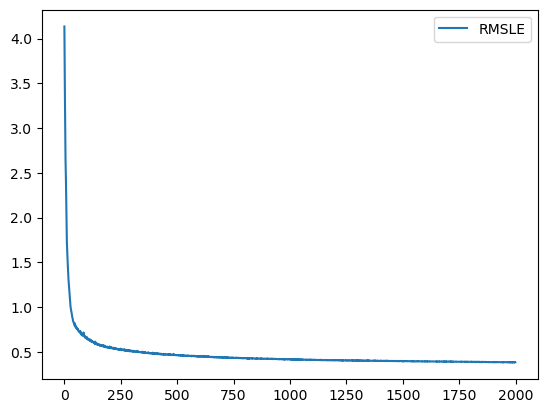

In [13]:
import matplotlib.pyplot as plt # for making figures
plt.plot(running_loss_es, label = "RMSLE")
plt.legend()

In [14]:
for param in model.parameters():
    print(param.data)

tensor([[ 2.4325e-03,  1.0952e-02,  5.6534e-03, -2.8736e-02, -1.6420e-01,
         -5.3972e+00, -8.5230e-02],
        [ 1.8769e-01,  3.9775e-02, -6.9110e-03,  2.6553e-02, -5.9642e-02,
          2.7687e-01,  1.3074e-02],
        [ 8.0049e-01, -1.2625e-02,  1.4264e-02, -1.2992e-01, -1.3145e-01,
         -6.4975e+00,  6.4371e-02],
        [ 1.5668e-02,  9.9014e-03,  2.1936e-03,  1.1465e-02, -1.4862e+00,
         -1.7299e-01, -6.4015e-02],
        [-5.9811e-02, -1.0436e-02, -1.1748e-03,  1.6153e-02, -1.3884e+00,
         -1.1395e+01,  1.3117e-01],
        [ 1.8450e-02,  2.5170e-02, -2.0081e-03,  1.3996e-01, -4.6857e+00,
          6.6744e-02,  5.9539e-02],
        [-1.3416e-02, -6.0432e-01,  6.1579e-01, -1.0862e-02, -1.1060e-02,
         -3.8493e-03, -1.3366e-02],
        [-1.4580e+00, -1.8733e-02,  6.1371e-02, -4.3014e-04,  1.1356e-01,
         -5.3769e+00, -1.2019e-01],
        [-6.6715e-03,  4.5839e-04, -2.5750e-03,  8.0406e-04, -7.3278e-01,
          7.4905e-02,  1.7684e-01],
        [ 

In [14]:
# Set the model to evaluation mode
model.eval()
machine_epsilon = 1
# Initialize the total loss and accuracy
total_loss = 0
total_correct = 0
total_samples = 0
machine_epsilon = train_sales_log.std()/10 
# Disable gradient calculation
with torch.no_grad():
    # Loop over the validation set
    for batch_data, batch_labels in val_loader:
        # Move the data and labels to the device
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)
        batch_labels = batch_labels.squeeze(-1)
        # Forward pass
        outputs = model(batch_data)
        outputs = outputs.squeeze(-1)
        
        batch_labels = torch.exp(batch_labels)-1
        outputs = torch.exp(outputs)-1
        
        # Calculate the loss
        loss = criterion(outputs, batch_labels)
        # Accumulate the loss
        total_loss += loss.item() * batch_data.size(0)

        # Get the predicted class
        
        
        # Count the number of correct predictions
        total_correct += ((
            (outputs - batch_labels)**2)<machine_epsilon).sum().item()

        # Increment the total number of samples
        total_samples += batch_data.size(0)
        #break
# Calculate the average loss and accuracy over the validation set
average_loss = total_loss / total_samples
accuracy = total_correct / total_samples

# Print the results
print('Validation Loss: {:.4f}'.format(average_loss))

Validation Loss: 0.3828


In [15]:
def evaluate(model_file, val_loader):
    # Load the neural network from file
    model = torch.load(model_file)
    print('Testing model ' + model_file)
    # Get the name of the model
    model_name = model_file.split("/")[-1]
    
    # Evaluate the neural network on the testing set
    total_loss = 0
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
            # Loop over the validation set
        for batch_data, batch_labels in val_loader:
            # Move the data and labels to the device
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)

            # Forward pass
            outputs = model(batch_data)
            outputs = outputs.squeeze(-1)
            #batch_labels = torch.squeeze(-1)
            
            batch_labels = torch.exp(batch_labels)-1
            outputs = torch.exp(outputs)-1
        

            # Calculate the loss
            loss = criterion(outputs, batch_labels)
            
            # Accumulate the loss
            total_loss += loss.item() * batch_data.size(0)

            # Get the predicted class
            # Count the number of correct predictions
            total_correct += (
                    ((outputs - batch_labels)**2)<machine_epsilon).sum().item()
    
            # Increment the total number of samples
            total_samples += batch_data.size(0)

# Calculate the average loss and accuracy over the validation set
    average_loss = total_loss / total_samples
    #accuracy = total_correct / total_samples

# Print the results
    #accuracy = 0
    print('Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%'.format(average_loss, accuracy * 100))
    return average_loss

In [16]:
val_loss = []
for i in range(train_iterations):
    if (i % save_every == 0):
        #print(i)
        val_loss.append(evaluate(f'weights/model_weights_{i}.pth',val_loader))

Testing model weights/model_weights_0.pth
Validation Loss: 3.8831, Validation Accuracy: 29.70%
Testing model weights/model_weights_1.pth
Validation Loss: 3.5747, Validation Accuracy: 29.70%
Testing model weights/model_weights_2.pth
Validation Loss: 3.3210, Validation Accuracy: 29.70%
Testing model weights/model_weights_3.pth
Validation Loss: 2.9088, Validation Accuracy: 29.70%
Testing model weights/model_weights_4.pth
Validation Loss: 2.6296, Validation Accuracy: 29.70%
Testing model weights/model_weights_5.pth
Validation Loss: 2.5462, Validation Accuracy: 29.70%
Testing model weights/model_weights_6.pth
Validation Loss: 2.4598, Validation Accuracy: 29.70%
Testing model weights/model_weights_7.pth
Validation Loss: 2.2827, Validation Accuracy: 29.70%
Testing model weights/model_weights_8.pth
Validation Loss: 2.1737, Validation Accuracy: 29.70%
Testing model weights/model_weights_9.pth
Validation Loss: 1.9292, Validation Accuracy: 29.70%
Testing model weights/model_weights_10.pth
Validat

Validation Loss: 0.6549, Validation Accuracy: 29.70%
Testing model weights/model_weights_86.pth
Validation Loss: 0.6610, Validation Accuracy: 29.70%
Testing model weights/model_weights_87.pth
Validation Loss: 0.7512, Validation Accuracy: 29.70%
Testing model weights/model_weights_88.pth
Validation Loss: 0.7315, Validation Accuracy: 29.70%
Testing model weights/model_weights_89.pth
Validation Loss: 0.6605, Validation Accuracy: 29.70%
Testing model weights/model_weights_90.pth
Validation Loss: 0.8544, Validation Accuracy: 29.70%
Testing model weights/model_weights_91.pth
Validation Loss: 0.6307, Validation Accuracy: 29.70%
Testing model weights/model_weights_92.pth
Validation Loss: 0.6346, Validation Accuracy: 29.70%
Testing model weights/model_weights_93.pth
Validation Loss: 0.6227, Validation Accuracy: 29.70%
Testing model weights/model_weights_94.pth
Validation Loss: 0.6282, Validation Accuracy: 29.70%
Testing model weights/model_weights_95.pth
Validation Loss: 0.6367, Validation Accu

Validation Loss: 0.5436, Validation Accuracy: 29.70%
Testing model weights/model_weights_171.pth
Validation Loss: 0.5486, Validation Accuracy: 29.70%
Testing model weights/model_weights_172.pth
Validation Loss: 0.5436, Validation Accuracy: 29.70%
Testing model weights/model_weights_173.pth
Validation Loss: 0.5478, Validation Accuracy: 29.70%
Testing model weights/model_weights_174.pth
Validation Loss: 0.5480, Validation Accuracy: 29.70%
Testing model weights/model_weights_175.pth
Validation Loss: 0.5334, Validation Accuracy: 29.70%
Testing model weights/model_weights_176.pth
Validation Loss: 0.5938, Validation Accuracy: 29.70%
Testing model weights/model_weights_177.pth
Validation Loss: 0.5629, Validation Accuracy: 29.70%
Testing model weights/model_weights_178.pth
Validation Loss: 0.5504, Validation Accuracy: 29.70%
Testing model weights/model_weights_179.pth
Validation Loss: 0.5587, Validation Accuracy: 29.70%
Testing model weights/model_weights_180.pth
Validation Loss: 0.5552, Valid

Validation Loss: 0.5016, Validation Accuracy: 29.70%
Testing model weights/model_weights_256.pth
Validation Loss: 0.5279, Validation Accuracy: 29.70%
Testing model weights/model_weights_257.pth
Validation Loss: 0.5211, Validation Accuracy: 29.70%
Testing model weights/model_weights_258.pth
Validation Loss: 0.5115, Validation Accuracy: 29.70%
Testing model weights/model_weights_259.pth
Validation Loss: 0.5250, Validation Accuracy: 29.70%
Testing model weights/model_weights_260.pth
Validation Loss: 0.5518, Validation Accuracy: 29.70%
Testing model weights/model_weights_261.pth
Validation Loss: 0.5288, Validation Accuracy: 29.70%
Testing model weights/model_weights_262.pth
Validation Loss: 0.5339, Validation Accuracy: 29.70%
Testing model weights/model_weights_263.pth
Validation Loss: 0.5203, Validation Accuracy: 29.70%
Testing model weights/model_weights_264.pth
Validation Loss: 0.5161, Validation Accuracy: 29.70%
Testing model weights/model_weights_265.pth
Validation Loss: 0.5009, Valid

Validation Loss: 0.4769, Validation Accuracy: 29.70%
Testing model weights/model_weights_341.pth
Validation Loss: 0.5078, Validation Accuracy: 29.70%
Testing model weights/model_weights_342.pth
Validation Loss: 0.4992, Validation Accuracy: 29.70%
Testing model weights/model_weights_343.pth
Validation Loss: 0.4911, Validation Accuracy: 29.70%
Testing model weights/model_weights_344.pth
Validation Loss: 0.4834, Validation Accuracy: 29.70%
Testing model weights/model_weights_345.pth
Validation Loss: 0.4912, Validation Accuracy: 29.70%
Testing model weights/model_weights_346.pth
Validation Loss: 0.4884, Validation Accuracy: 29.70%
Testing model weights/model_weights_347.pth
Validation Loss: 0.5049, Validation Accuracy: 29.70%
Testing model weights/model_weights_348.pth
Validation Loss: 0.5183, Validation Accuracy: 29.70%
Testing model weights/model_weights_349.pth
Validation Loss: 0.4666, Validation Accuracy: 29.70%
Testing model weights/model_weights_350.pth
Validation Loss: 0.4823, Valid

Validation Loss: 0.4617, Validation Accuracy: 29.70%
Testing model weights/model_weights_426.pth
Validation Loss: 0.5218, Validation Accuracy: 29.70%
Testing model weights/model_weights_427.pth
Validation Loss: 0.4856, Validation Accuracy: 29.70%
Testing model weights/model_weights_428.pth
Validation Loss: 0.4568, Validation Accuracy: 29.70%
Testing model weights/model_weights_429.pth
Validation Loss: 0.4844, Validation Accuracy: 29.70%
Testing model weights/model_weights_430.pth
Validation Loss: 0.4567, Validation Accuracy: 29.70%
Testing model weights/model_weights_431.pth
Validation Loss: 0.5376, Validation Accuracy: 29.70%
Testing model weights/model_weights_432.pth
Validation Loss: 0.4688, Validation Accuracy: 29.70%
Testing model weights/model_weights_433.pth
Validation Loss: 0.4721, Validation Accuracy: 29.70%
Testing model weights/model_weights_434.pth
Validation Loss: 0.4749, Validation Accuracy: 29.70%
Testing model weights/model_weights_435.pth
Validation Loss: 0.4574, Valid

Validation Loss: 0.4559, Validation Accuracy: 29.70%
Testing model weights/model_weights_511.pth
Validation Loss: 0.4868, Validation Accuracy: 29.70%
Testing model weights/model_weights_512.pth
Validation Loss: 0.4606, Validation Accuracy: 29.70%
Testing model weights/model_weights_513.pth
Validation Loss: 0.4678, Validation Accuracy: 29.70%
Testing model weights/model_weights_514.pth
Validation Loss: 0.5226, Validation Accuracy: 29.70%
Testing model weights/model_weights_515.pth
Validation Loss: 0.5046, Validation Accuracy: 29.70%
Testing model weights/model_weights_516.pth
Validation Loss: 0.4669, Validation Accuracy: 29.70%
Testing model weights/model_weights_517.pth
Validation Loss: 0.4679, Validation Accuracy: 29.70%
Testing model weights/model_weights_518.pth
Validation Loss: 0.4629, Validation Accuracy: 29.70%
Testing model weights/model_weights_519.pth
Validation Loss: 0.4483, Validation Accuracy: 29.70%
Testing model weights/model_weights_520.pth
Validation Loss: 0.4450, Valid

Validation Loss: 0.4530, Validation Accuracy: 29.70%
Testing model weights/model_weights_596.pth
Validation Loss: 0.5493, Validation Accuracy: 29.70%
Testing model weights/model_weights_597.pth
Validation Loss: 0.4347, Validation Accuracy: 29.70%
Testing model weights/model_weights_598.pth
Validation Loss: 0.4464, Validation Accuracy: 29.70%
Testing model weights/model_weights_599.pth
Validation Loss: 0.4499, Validation Accuracy: 29.70%
Testing model weights/model_weights_600.pth
Validation Loss: 0.4393, Validation Accuracy: 29.70%
Testing model weights/model_weights_601.pth
Validation Loss: 0.4466, Validation Accuracy: 29.70%
Testing model weights/model_weights_602.pth
Validation Loss: 0.4525, Validation Accuracy: 29.70%
Testing model weights/model_weights_603.pth
Validation Loss: 0.4858, Validation Accuracy: 29.70%
Testing model weights/model_weights_604.pth
Validation Loss: 0.4399, Validation Accuracy: 29.70%
Testing model weights/model_weights_605.pth
Validation Loss: 0.4582, Valid

Validation Loss: 0.4975, Validation Accuracy: 29.70%
Testing model weights/model_weights_681.pth
Validation Loss: 0.4643, Validation Accuracy: 29.70%
Testing model weights/model_weights_682.pth
Validation Loss: 0.4242, Validation Accuracy: 29.70%
Testing model weights/model_weights_683.pth
Validation Loss: 0.4266, Validation Accuracy: 29.70%
Testing model weights/model_weights_684.pth
Validation Loss: 0.5069, Validation Accuracy: 29.70%
Testing model weights/model_weights_685.pth
Validation Loss: 0.4739, Validation Accuracy: 29.70%
Testing model weights/model_weights_686.pth
Validation Loss: 0.4389, Validation Accuracy: 29.70%
Testing model weights/model_weights_687.pth
Validation Loss: 0.4252, Validation Accuracy: 29.70%
Testing model weights/model_weights_688.pth
Validation Loss: 0.4664, Validation Accuracy: 29.70%
Testing model weights/model_weights_689.pth
Validation Loss: 0.4206, Validation Accuracy: 29.70%
Testing model weights/model_weights_690.pth
Validation Loss: 0.4458, Valid

Validation Loss: 0.4184, Validation Accuracy: 29.70%
Testing model weights/model_weights_766.pth
Validation Loss: 0.4445, Validation Accuracy: 29.70%
Testing model weights/model_weights_767.pth
Validation Loss: 0.4382, Validation Accuracy: 29.70%
Testing model weights/model_weights_768.pth
Validation Loss: 0.4309, Validation Accuracy: 29.70%
Testing model weights/model_weights_769.pth
Validation Loss: 0.4198, Validation Accuracy: 29.70%
Testing model weights/model_weights_770.pth
Validation Loss: 0.4545, Validation Accuracy: 29.70%
Testing model weights/model_weights_771.pth
Validation Loss: 0.4720, Validation Accuracy: 29.70%
Testing model weights/model_weights_772.pth
Validation Loss: 0.4787, Validation Accuracy: 29.70%
Testing model weights/model_weights_773.pth
Validation Loss: 0.4230, Validation Accuracy: 29.70%
Testing model weights/model_weights_774.pth
Validation Loss: 0.4217, Validation Accuracy: 29.70%
Testing model weights/model_weights_775.pth
Validation Loss: 0.4249, Valid

Validation Loss: 0.4272, Validation Accuracy: 29.70%
Testing model weights/model_weights_851.pth
Validation Loss: 0.4155, Validation Accuracy: 29.70%
Testing model weights/model_weights_852.pth
Validation Loss: 0.4163, Validation Accuracy: 29.70%
Testing model weights/model_weights_853.pth
Validation Loss: 0.4187, Validation Accuracy: 29.70%
Testing model weights/model_weights_854.pth
Validation Loss: 0.4387, Validation Accuracy: 29.70%
Testing model weights/model_weights_855.pth
Validation Loss: 0.4237, Validation Accuracy: 29.70%
Testing model weights/model_weights_856.pth
Validation Loss: 0.4342, Validation Accuracy: 29.70%
Testing model weights/model_weights_857.pth
Validation Loss: 0.4133, Validation Accuracy: 29.70%
Testing model weights/model_weights_858.pth
Validation Loss: 0.4267, Validation Accuracy: 29.70%
Testing model weights/model_weights_859.pth
Validation Loss: 0.4307, Validation Accuracy: 29.70%
Testing model weights/model_weights_860.pth
Validation Loss: 0.4046, Valid

Validation Loss: 0.4138, Validation Accuracy: 29.70%
Testing model weights/model_weights_936.pth
Validation Loss: 0.4294, Validation Accuracy: 29.70%
Testing model weights/model_weights_937.pth
Validation Loss: 0.4301, Validation Accuracy: 29.70%
Testing model weights/model_weights_938.pth
Validation Loss: 0.4292, Validation Accuracy: 29.70%
Testing model weights/model_weights_939.pth
Validation Loss: 0.4174, Validation Accuracy: 29.70%
Testing model weights/model_weights_940.pth
Validation Loss: 0.4311, Validation Accuracy: 29.70%
Testing model weights/model_weights_941.pth
Validation Loss: 0.4130, Validation Accuracy: 29.70%
Testing model weights/model_weights_942.pth
Validation Loss: 0.4150, Validation Accuracy: 29.70%
Testing model weights/model_weights_943.pth
Validation Loss: 0.4175, Validation Accuracy: 29.70%
Testing model weights/model_weights_944.pth
Validation Loss: 0.4356, Validation Accuracy: 29.70%
Testing model weights/model_weights_945.pth
Validation Loss: 0.4224, Valid

Validation Loss: 0.4311, Validation Accuracy: 29.70%
Testing model weights/model_weights_1021.pth
Validation Loss: 0.4348, Validation Accuracy: 29.70%
Testing model weights/model_weights_1022.pth
Validation Loss: 0.4113, Validation Accuracy: 29.70%
Testing model weights/model_weights_1023.pth
Validation Loss: 0.5427, Validation Accuracy: 29.70%
Testing model weights/model_weights_1024.pth
Validation Loss: 0.4591, Validation Accuracy: 29.70%
Testing model weights/model_weights_1025.pth
Validation Loss: 0.4270, Validation Accuracy: 29.70%
Testing model weights/model_weights_1026.pth
Validation Loss: 0.4085, Validation Accuracy: 29.70%
Testing model weights/model_weights_1027.pth
Validation Loss: 0.4107, Validation Accuracy: 29.70%
Testing model weights/model_weights_1028.pth
Validation Loss: 0.4027, Validation Accuracy: 29.70%
Testing model weights/model_weights_1029.pth
Validation Loss: 0.4294, Validation Accuracy: 29.70%
Testing model weights/model_weights_1030.pth
Validation Loss: 0.4

Validation Loss: 0.4429, Validation Accuracy: 29.70%
Testing model weights/model_weights_1105.pth
Validation Loss: 0.4342, Validation Accuracy: 29.70%
Testing model weights/model_weights_1106.pth
Validation Loss: 0.4511, Validation Accuracy: 29.70%
Testing model weights/model_weights_1107.pth
Validation Loss: 0.4077, Validation Accuracy: 29.70%
Testing model weights/model_weights_1108.pth
Validation Loss: 0.4135, Validation Accuracy: 29.70%
Testing model weights/model_weights_1109.pth
Validation Loss: 0.4272, Validation Accuracy: 29.70%
Testing model weights/model_weights_1110.pth
Validation Loss: 0.4289, Validation Accuracy: 29.70%
Testing model weights/model_weights_1111.pth
Validation Loss: 0.4088, Validation Accuracy: 29.70%
Testing model weights/model_weights_1112.pth
Validation Loss: 0.4055, Validation Accuracy: 29.70%
Testing model weights/model_weights_1113.pth
Validation Loss: 0.4210, Validation Accuracy: 29.70%
Testing model weights/model_weights_1114.pth
Validation Loss: 0.4

Validation Loss: 0.4775, Validation Accuracy: 29.70%
Testing model weights/model_weights_1189.pth
Validation Loss: 0.4070, Validation Accuracy: 29.70%
Testing model weights/model_weights_1190.pth
Validation Loss: 0.4156, Validation Accuracy: 29.70%
Testing model weights/model_weights_1191.pth
Validation Loss: 0.4105, Validation Accuracy: 29.70%
Testing model weights/model_weights_1192.pth
Validation Loss: 0.3964, Validation Accuracy: 29.70%
Testing model weights/model_weights_1193.pth
Validation Loss: 0.3940, Validation Accuracy: 29.70%
Testing model weights/model_weights_1194.pth
Validation Loss: 0.4143, Validation Accuracy: 29.70%
Testing model weights/model_weights_1195.pth
Validation Loss: 0.4139, Validation Accuracy: 29.70%
Testing model weights/model_weights_1196.pth
Validation Loss: 0.4096, Validation Accuracy: 29.70%
Testing model weights/model_weights_1197.pth
Validation Loss: 0.4155, Validation Accuracy: 29.70%
Testing model weights/model_weights_1198.pth
Validation Loss: 0.4

Validation Loss: 0.4110, Validation Accuracy: 29.70%
Testing model weights/model_weights_1273.pth
Validation Loss: 0.4017, Validation Accuracy: 29.70%
Testing model weights/model_weights_1274.pth
Validation Loss: 0.4112, Validation Accuracy: 29.70%
Testing model weights/model_weights_1275.pth
Validation Loss: 0.4024, Validation Accuracy: 29.70%
Testing model weights/model_weights_1276.pth
Validation Loss: 0.4172, Validation Accuracy: 29.70%
Testing model weights/model_weights_1277.pth
Validation Loss: 0.3951, Validation Accuracy: 29.70%
Testing model weights/model_weights_1278.pth
Validation Loss: 0.4935, Validation Accuracy: 29.70%
Testing model weights/model_weights_1279.pth
Validation Loss: 0.4332, Validation Accuracy: 29.70%
Testing model weights/model_weights_1280.pth
Validation Loss: 0.4548, Validation Accuracy: 29.70%
Testing model weights/model_weights_1281.pth
Validation Loss: 0.4070, Validation Accuracy: 29.70%
Testing model weights/model_weights_1282.pth
Validation Loss: 0.4

Validation Loss: 0.4139, Validation Accuracy: 29.70%
Testing model weights/model_weights_1357.pth
Validation Loss: 0.4084, Validation Accuracy: 29.70%
Testing model weights/model_weights_1358.pth
Validation Loss: 0.4218, Validation Accuracy: 29.70%
Testing model weights/model_weights_1359.pth
Validation Loss: 0.4015, Validation Accuracy: 29.70%
Testing model weights/model_weights_1360.pth
Validation Loss: 0.4006, Validation Accuracy: 29.70%
Testing model weights/model_weights_1361.pth
Validation Loss: 0.4245, Validation Accuracy: 29.70%
Testing model weights/model_weights_1362.pth
Validation Loss: 0.3843, Validation Accuracy: 29.70%
Testing model weights/model_weights_1363.pth
Validation Loss: 0.5089, Validation Accuracy: 29.70%
Testing model weights/model_weights_1364.pth
Validation Loss: 0.4245, Validation Accuracy: 29.70%
Testing model weights/model_weights_1365.pth
Validation Loss: 0.4056, Validation Accuracy: 29.70%
Testing model weights/model_weights_1366.pth
Validation Loss: 0.4

Validation Loss: 0.4625, Validation Accuracy: 29.70%
Testing model weights/model_weights_1441.pth
Validation Loss: 0.4005, Validation Accuracy: 29.70%
Testing model weights/model_weights_1442.pth
Validation Loss: 0.4130, Validation Accuracy: 29.70%
Testing model weights/model_weights_1443.pth
Validation Loss: 0.3868, Validation Accuracy: 29.70%
Testing model weights/model_weights_1444.pth
Validation Loss: 0.3924, Validation Accuracy: 29.70%
Testing model weights/model_weights_1445.pth
Validation Loss: 0.4211, Validation Accuracy: 29.70%
Testing model weights/model_weights_1446.pth
Validation Loss: 0.3985, Validation Accuracy: 29.70%
Testing model weights/model_weights_1447.pth
Validation Loss: 0.4227, Validation Accuracy: 29.70%
Testing model weights/model_weights_1448.pth
Validation Loss: 0.4029, Validation Accuracy: 29.70%
Testing model weights/model_weights_1449.pth
Validation Loss: 0.4050, Validation Accuracy: 29.70%
Testing model weights/model_weights_1450.pth
Validation Loss: 0.4

Validation Loss: 0.3909, Validation Accuracy: 29.70%
Testing model weights/model_weights_1525.pth
Validation Loss: 0.3822, Validation Accuracy: 29.70%
Testing model weights/model_weights_1526.pth
Validation Loss: 0.4225, Validation Accuracy: 29.70%
Testing model weights/model_weights_1527.pth
Validation Loss: 0.4331, Validation Accuracy: 29.70%
Testing model weights/model_weights_1528.pth
Validation Loss: 0.4179, Validation Accuracy: 29.70%
Testing model weights/model_weights_1529.pth
Validation Loss: 0.3915, Validation Accuracy: 29.70%
Testing model weights/model_weights_1530.pth
Validation Loss: 0.3817, Validation Accuracy: 29.70%
Testing model weights/model_weights_1531.pth
Validation Loss: 0.3929, Validation Accuracy: 29.70%
Testing model weights/model_weights_1532.pth
Validation Loss: 0.4031, Validation Accuracy: 29.70%
Testing model weights/model_weights_1533.pth
Validation Loss: 0.4110, Validation Accuracy: 29.70%
Testing model weights/model_weights_1534.pth
Validation Loss: 0.3

Validation Loss: 0.3950, Validation Accuracy: 29.70%
Testing model weights/model_weights_1609.pth
Validation Loss: 0.3890, Validation Accuracy: 29.70%
Testing model weights/model_weights_1610.pth
Validation Loss: 0.4076, Validation Accuracy: 29.70%
Testing model weights/model_weights_1611.pth
Validation Loss: 0.3940, Validation Accuracy: 29.70%
Testing model weights/model_weights_1612.pth
Validation Loss: 0.3906, Validation Accuracy: 29.70%
Testing model weights/model_weights_1613.pth
Validation Loss: 0.4032, Validation Accuracy: 29.70%
Testing model weights/model_weights_1614.pth
Validation Loss: 0.3944, Validation Accuracy: 29.70%
Testing model weights/model_weights_1615.pth
Validation Loss: 0.3977, Validation Accuracy: 29.70%
Testing model weights/model_weights_1616.pth
Validation Loss: 0.4337, Validation Accuracy: 29.70%
Testing model weights/model_weights_1617.pth
Validation Loss: 0.3978, Validation Accuracy: 29.70%
Testing model weights/model_weights_1618.pth
Validation Loss: 0.3

Validation Loss: 0.3969, Validation Accuracy: 29.70%
Testing model weights/model_weights_1693.pth
Validation Loss: 0.3765, Validation Accuracy: 29.70%
Testing model weights/model_weights_1694.pth
Validation Loss: 0.3960, Validation Accuracy: 29.70%
Testing model weights/model_weights_1695.pth
Validation Loss: 0.3854, Validation Accuracy: 29.70%
Testing model weights/model_weights_1696.pth
Validation Loss: 0.3931, Validation Accuracy: 29.70%
Testing model weights/model_weights_1697.pth
Validation Loss: 0.4066, Validation Accuracy: 29.70%
Testing model weights/model_weights_1698.pth
Validation Loss: 0.3934, Validation Accuracy: 29.70%
Testing model weights/model_weights_1699.pth
Validation Loss: 0.4032, Validation Accuracy: 29.70%
Testing model weights/model_weights_1700.pth
Validation Loss: 0.4027, Validation Accuracy: 29.70%
Testing model weights/model_weights_1701.pth
Validation Loss: 0.3960, Validation Accuracy: 29.70%
Testing model weights/model_weights_1702.pth
Validation Loss: 0.3

Validation Loss: 0.4202, Validation Accuracy: 29.70%
Testing model weights/model_weights_1777.pth
Validation Loss: 0.3775, Validation Accuracy: 29.70%
Testing model weights/model_weights_1778.pth
Validation Loss: 0.3898, Validation Accuracy: 29.70%
Testing model weights/model_weights_1779.pth
Validation Loss: 0.4347, Validation Accuracy: 29.70%
Testing model weights/model_weights_1780.pth
Validation Loss: 0.4259, Validation Accuracy: 29.70%
Testing model weights/model_weights_1781.pth
Validation Loss: 0.3893, Validation Accuracy: 29.70%
Testing model weights/model_weights_1782.pth
Validation Loss: 0.3966, Validation Accuracy: 29.70%
Testing model weights/model_weights_1783.pth
Validation Loss: 0.4009, Validation Accuracy: 29.70%
Testing model weights/model_weights_1784.pth
Validation Loss: 0.3941, Validation Accuracy: 29.70%
Testing model weights/model_weights_1785.pth
Validation Loss: 0.3989, Validation Accuracy: 29.70%
Testing model weights/model_weights_1786.pth
Validation Loss: 0.3

Validation Loss: 0.3823, Validation Accuracy: 29.70%
Testing model weights/model_weights_1861.pth
Validation Loss: 0.3777, Validation Accuracy: 29.70%
Testing model weights/model_weights_1862.pth
Validation Loss: 0.4254, Validation Accuracy: 29.70%
Testing model weights/model_weights_1863.pth
Validation Loss: 0.4090, Validation Accuracy: 29.70%
Testing model weights/model_weights_1864.pth
Validation Loss: 0.3854, Validation Accuracy: 29.70%
Testing model weights/model_weights_1865.pth
Validation Loss: 0.4151, Validation Accuracy: 29.70%
Testing model weights/model_weights_1866.pth
Validation Loss: 0.3877, Validation Accuracy: 29.70%
Testing model weights/model_weights_1867.pth
Validation Loss: 0.3994, Validation Accuracy: 29.70%
Testing model weights/model_weights_1868.pth
Validation Loss: 0.3881, Validation Accuracy: 29.70%
Testing model weights/model_weights_1869.pth
Validation Loss: 0.3869, Validation Accuracy: 29.70%
Testing model weights/model_weights_1870.pth
Validation Loss: 0.4

Validation Loss: 0.3886, Validation Accuracy: 29.70%
Testing model weights/model_weights_1945.pth
Validation Loss: 0.3842, Validation Accuracy: 29.70%
Testing model weights/model_weights_1946.pth
Validation Loss: 0.3712, Validation Accuracy: 29.70%
Testing model weights/model_weights_1947.pth
Validation Loss: 0.3853, Validation Accuracy: 29.70%
Testing model weights/model_weights_1948.pth
Validation Loss: 0.3966, Validation Accuracy: 29.70%
Testing model weights/model_weights_1949.pth
Validation Loss: 0.3870, Validation Accuracy: 29.70%
Testing model weights/model_weights_1950.pth
Validation Loss: 0.3859, Validation Accuracy: 29.70%
Testing model weights/model_weights_1951.pth
Validation Loss: 0.3985, Validation Accuracy: 29.70%
Testing model weights/model_weights_1952.pth
Validation Loss: 0.3836, Validation Accuracy: 29.70%
Testing model weights/model_weights_1953.pth
Validation Loss: 0.3908, Validation Accuracy: 29.70%
Testing model weights/model_weights_1954.pth
Validation Loss: 0.3

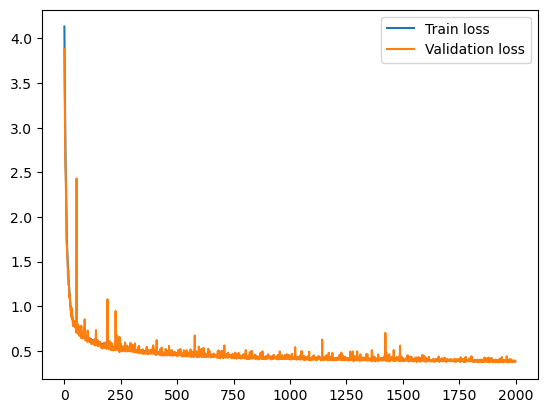

In [17]:
plt.plot(running_loss_es, label = "Train loss")
plt.plot(val_loss, label = "Validation loss")
plt.legend()

In [20]:
!systemctl suspend

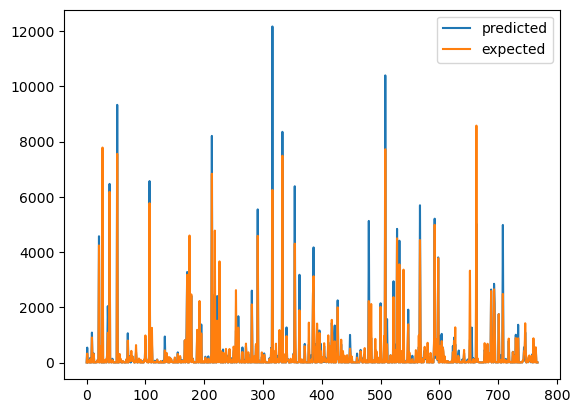

In [21]:
with torch.no_grad():

    for batch_data, batch_labels in val_loader:
        # Move the data and labels to the device
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)

        # Forward pass
        outputs = model(batch_data)
        outputs = outputs.squeeze(-1)
        #batch_labels = torch.squeeze(-1)

        batch_labels = torch.exp(batch_labels)+1
        outputs = torch.exp(outputs)+1


        # Calculate the loss
        loss = criterion(outputs, batch_labels)
        plt.plot(outputs.numpy(), label = "predicted")
        plt.plot(batch_labels.numpy(), label = "expected")
        plt.legend()
        break

loss = 0.259419709444046


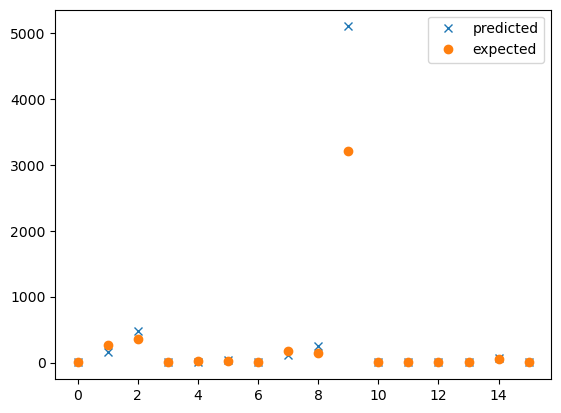

In [23]:
with torch.no_grad():
    evalutaion_val_dataset = val_loader.dataset
    n_samples = len(evalutaion_val_dataset)
    outputs = []
    expections = []
    for i in range(16):
    # Get a random sample
        random_index = int(np.random.random()*n_samples)
        single_example = evalutaion_val_dataset[random_index]
        output = model(single_example[0])
        output = torch.exp(output)+1
        outputs.append(output)
        expections.append(np.exp(single_example[1])+1)
        
    loss = criterion(torch.FloatTensor(outputs).squeeze(-1), torch.FloatTensor(expections).squeeze(-1))
    plt.plot(outputs, label = "predicted", linestyle="",marker="x")
    plt.plot(expections, label = "expected", linestyle="",marker="o")
    plt.legend()
    print(f'loss = {loss}')


In [60]:
evaluate(f'model_weights_32.pth',val_loader)

Testing model model_weights_32.pth
Validation Loss: 0.7605, Validation Accuracy: 0.00%


0

Commiting tests

In [24]:
import pandas as pd

# read the test.csv file
test_df = pd.read_csv('test.csv')

# read the oil.csv file
oil_df = pd.read_csv('oil.csv')

# fill missing values in dcoilwtico column with previous day's value
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].fillna(method='ffill')

# merge the two dataframes based on the 'date' column using left join
test_merged_df = pd.merge(test_df, oil_df[['date', 'dcoilwtico']], on='date', how='left')

# fill remaining missing values in dcoilwtico column with previous day's value
test_merged_df['dcoilwtico'] = test_merged_df['dcoilwtico'].fillna(method='ffill')





In [25]:
test_store_nbr = torch.tensor(test_merged_df['store_nbr'].values)
#test_train_sales = torch.tensor(merged_df['sales'].values, dtype=torch.float)
test_onpromotion = torch.tensor(test_merged_df['onpromotion'].values)
test_dcoilwtico = torch.tensor(test_merged_df['dcoilwtico'].values, dtype=torch.float)


# Convert string dates to datetime objects
test_test_dates = pd.to_datetime(test_merged_df['date'], format='%Y-%m-%d')
#I suppose that day of week is important to predict sales
test_day_of_week = test_test_dates.dt.weekday + 1
test_day_of_week = torch.from_numpy(test_day_of_week.to_numpy())
test_day_of_week = test_day_of_week.type(torch.float32)

test_day_of_month = test_test_dates.dt.day
test_day_of_month = torch.from_numpy(test_day_of_month.to_numpy())
test_day_of_month = test_day_of_month.type(torch.float32)
test_day_since_paycheck = []
for i in test_day_of_month:
    if(i>=15 and i <31):
        test_day_since_paycheck.append(i-15)
    if(i<15):
        test_day_since_paycheck.append(i)
    if (i == 31):
        test_day_since_paycheck.append(0) #more dirt, but better data
#Да это высчиытвается криво. Но сейчас пять утра, и мне лень это чинить. Если MSE станет ниже - починю
test_day_since_paycheck = torch.FloatTensor(test_day_since_paycheck)

test_month = test_test_dates.dt.month + 1 
test_month = torch.from_numpy(test_month.to_numpy()).float()
# Subtract datetime object representing "2013-01-01" to get number of days
#days_since_2013_01_01 = (dates - datetime(2013, 1, 1)).dt.days

# Convert to PyTorch tensor
#date = torch.from_numpy(days_since_2013_01_01.to_numpy())
test_family = []

test_family_raw = test_merged_df['family'].values
#families = sorted(list(set(family_raw)))
#stoi = {s:i+1 for i,s in enumerate(families)}
#itos = {i:s for s,i in stoi.items()}
#vocab_size = len(itos)
for i in test_family_raw:
    test_family.append(stoi[i])

test_family = torch.FloatTensor(test_family)


In [26]:
#print(train_sales.shape, train_sales.dtype)
print(test_store_nbr.shape, test_store_nbr.dtype)
print(test_onpromotion.shape, test_onpromotion.dtype)
print(test_family.shape, test_family.dtype)
print(test_day_of_week.shape, day_of_week.dtype)
print(test_month.shape, test_month.dtype)
print(test_day_since_paycheck.shape, test_day_since_paycheck.dtype)
print(test_dcoilwtico.shape, dcoilwtico.dtype)

torch.Size([28512]) torch.int64
torch.Size([28512]) torch.int64
torch.Size([28512]) torch.float32
torch.Size([28512]) torch.float32
torch.Size([28512]) torch.float32
torch.Size([28512]) torch.float32
torch.Size([28512]) torch.float32


In [27]:
test_data = torch.cat((test_month.unsqueeze(1), test_day_of_week.unsqueeze(1),test_day_since_paycheck.unsqueeze(1),
                        test_store_nbr.unsqueeze(1), test_family.unsqueeze(1),  test_onpromotion.unsqueeze(1),
                        test_dcoilwtico.unsqueeze(1)
                           ), dim=1)

print(test_data.dtype)
print(test_data.shape, test_data.dtype)
print(test_data.shape, test_data.dtype)

torch.float32
torch.Size([28512, 7]) torch.float32
torch.Size([28512, 7]) torch.float32


In [28]:
all_predictions = []
submission_loader = DataLoader(test_data, batch_size=1, shuffle=False,num_workers=8)
with torch.no_grad():
    for i, (inputs) in enumerate(submission_loader):
        outputs = model(inputs)
        output = torch.exp(outputs)+1
        #_,predicted = torch.max(outputs.data, 1)
        all_predictions.append(output.item())
        #all_predictions.extend(predicted.numpy())
# Save the predictions to a new CSV file
startId = 3000888
#endId = 
results = [i for i in range(startId,3000888+len(all_predictions))]
df = pd.DataFrame({'id': results, 'sales': all_predictions})
df.to_csv('My_model_predictions.csv', index=False)

In [59]:
all_predictions

[tensor([[4.3124e+00],
         [2.0000e+00],
         [9.9405e+00],
         [2.8043e+03],
         [2.0000e+00],
         [5.2337e+02],
         [2.6940e+01],
         [9.7833e+02],
         [6.4027e+02],
         [1.8648e+02],
         [1.8325e+02],
         [1.2126e+02],
         [2.8367e+03],
         [2.9080e+01],
         [3.5146e+00],
         [2.1364e+01],
         [4.5891e+01],
         [2.0000e+00],
         [2.3657e+02],
         [1.4274e+01],
         [1.0255e+02],
         [5.0081e+01],
         [1.1497e+02],
         [3.8557e+00],
         [2.2250e+02],
         [2.4537e+02],
         [6.7328e+00],
         [1.1736e+01],
         [4.0107e+02],
         [9.6051e+01],
         [8.3075e+03],
         [2.0634e+02],
         [1.7124e+01],
         [5.3656e+00],
         [2.0000e+00],
         [7.6838e+00],
         [2.5055e+03],
         [2.0000e+00],
         [3.9718e+02],
         [8.7188e+00],
         [1.3139e+03],
         [4.5676e+02],
         [3.4781e+02],
         [1